## Cell Counting

This notebook provides you with a complete code example that counts the cells in a microscopic image using a U-Net.

## Loading the Dataset

This is the BBBC039v1 dataset by Caicedo et al. 2018, available from the Broad Bioimage Benchmark Collection https://data.broadinstitute.org/bbbc/BBBC039/ (Ljosa et al., Nature Methods, 2012).

This data set has a total of 200 fields of view of nuclei captured with fluorescence microscopy using the Hoechst stain. The collection has around 23,000 single nuclei manually annotated to establish a ground truth collection for segmentation evaluation.

The images are stored as TIFF files with 520 x 696 pixels at 16 bits. Ground truth annotations are stored as PNG files encoding masks of independent nuclei.

In [1]:
import os
import deeptrack as dt

if not os.path.exists("cell_counting_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/cell_counting_dataset")

image_paths = dt.sources.ImageFolder(
    root=os.path.join("cell_counting_dataset", "cell nuclei", "images")
)
label_paths = dt.sources.ImageFolder(
    root=os.path.join("cell_counting_dataset", "cell nuclei", "masks")
)
sources = dt.sources.Source(image=image_paths, label=label_paths)

Cloning into 'cell_counting_dataset'...
Updating files: 100% (401/401), done.


## Creating a Pipeline to Load the Images and Segmentation Masks

Create a pipeline to load the images and labels ...

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader

im_pipeline = (dt.LoadImage(sources.image.path) >> dt.Divide(3000)
               >> dt.Clip(0, 1) >> dt.AsType("float"))
lab_pipeline = dt.LoadImage(sources.label.path)[..., :1] >> dt.AsType("float")

pipeline = (
    (im_pipeline & lab_pipeline)
    >> dt.Crop(crop=(512, 688, None), corner=(0, 0))
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

test_dataset = dt.pytorch.Dataset(pipeline, sources)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

... count cells using connected components ...

In [3]:
from skimage import morphology as skmorph

image, mask = test_dataset[np.random.choice(len(test_dataset))]
labeled_mask = skmorph.label(mask)
number_of_cells = labeled_mask.max()

... and visualize the data.

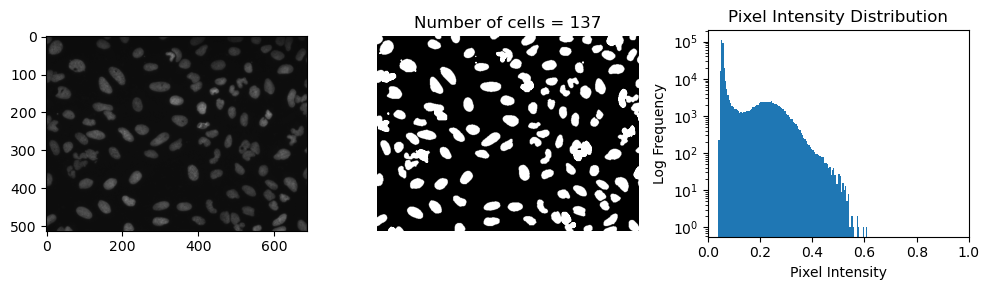

In [4]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].imshow(image.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")

axs[1].imshow(mask.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
axs[1].axis("off")
axs[1].set_title(f"Number of cells = {number_of_cells}")

axs[2].hist(np.array(image).flatten(), bins=200, range=(0, 1))
axs[2].set_xlim([0, 1])
axs[2].set_xlabel("Pixel Intensity")
axs[2].set_yscale("log")
axs[2].set_ylabel("Log Frequency")
axs[2].set_title("Pixel Intensity Distribution")

plt.tight_layout()
plt.show()

## Simulating the Cell Images and Segmentation Masks

### Simulating Images of Cell Nuclei

Simulate a single cell nucleus as an ellipse ...

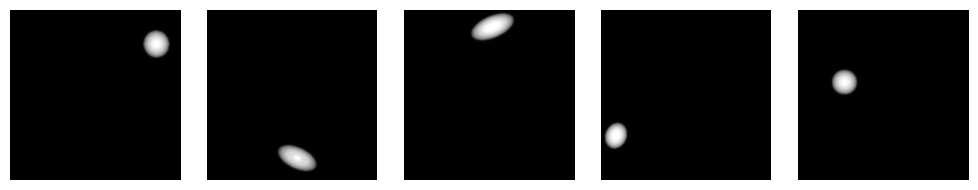

In [5]:
training_image_size = 256

def random_ellipse_radius():
    """Return the three axes of an ellipse."""
    desired_ellipse_area = (np.random.uniform(3, 4)) ** 2
    desired_radius_ratio = np.random.uniform(1, 1.5)
    major_axis_radius = np.sqrt(desired_ellipse_area) * desired_radius_ratio
    minor_axis_radius = np.sqrt(desired_ellipse_area) / desired_radius_ratio
    z_radius = np.sqrt(desired_ellipse_area) * np.random.uniform(0.2, 0.4)
    return (major_axis_radius, minor_axis_radius, z_radius) * dt.units.um

ellipse = dt.Ellipsoid(
    radius=random_ellipse_radius,
    intensity=lambda: np.random.uniform(0.5, 1.5),
    position=lambda: np.random.uniform(5, training_image_size - 5, size=2),
    rotation=lambda: np.random.uniform(0, 2 * np.pi),
)
optics = dt.Fluorescence(
    resolution=1e-6,
    magnification=6,
    wavelength=400e-9,
    NA=lambda: np.random.uniform(0.9, 1.1),
    output_region=(0, 0, training_image_size, training_image_size),
)
image_pipeline = optics(ellipse)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for ax in axs:
    image_pipeline.update()
    image = image_pipeline()
    ax.imshow(image, cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()